In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
dataset_dir = '/content/drive/MyDrive/samples_segmented_chars'


In [10]:
import os

tar_files = [f for f in os.listdir(dataset_dir) if f.endswith('.tar')]
print(tar_files)



['p1_upload.tar']


In [11]:

import tarfile

for tar_name in tar_files:
    tar_path = os.path.join(dataset_dir, tar_name)
    extract_dir = dataset_dir

    os.makedirs(extract_dir, exist_ok=True)

    with tarfile.open(tar_path, 'r') as tar:
        tar.extractall(path=extract_dir)

    print(f'Extracted {tar_name} to {extract_dir}')

Extracted p1_upload.tar to /content/drive/MyDrive/samples_segmented_chars


In [25]:
import os
import cv2
import numpy as np
from skimage.morphology import skeletonize
from skimage.util import invert
from PIL import Image
from tqdm import tqdm

def skeletonize_image(img_path):
    # Load grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError(f"Could not load image: {img_path}")



    binary = (img == 0).astype(np.uint8)

    # Skeletonize
    skeleton = skeletonize(binary).astype(np.uint8) * 255  # convert to 0-255

    return skeleton


def process_dataset(input_root, output_root):
    for root, _, files in os.walk(input_root):
        for fname in files:
            if not fname.lower().endswith('.png'):
                continue
            in_path = os.path.join(root, fname)
            rel_path = os.path.relpath(in_path, input_root)
            out_path = os.path.join(output_root, rel_path)

            try:
                img = cv2.imread(in_path,cv2.IMREAD_GRAYSCALE)
                if img is None:
                  raise ValueError(f"Could not load image: {img_path}")
                img_gray = np.array(img)
                skeleton = preprocess_and_skeletonize(img_gray,apply_close=True)

                # Make sure output folder exists
                os.makedirs(os.path.dirname(out_path), exist_ok=True)

                # Save result
                Image.fromarray(skeleton).save(out_path)
            except Exception as e:
                print(f"Error processing {in_path}: {e}")

    print(f"All skeletonized images saved to: {output_root}")


In [24]:
img_path = "/content/drive/MyDrive/samples_segmented_chars/p1_upload/RC04846/page_1/c199.png"
img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError(f"Could not load image: {img_path}")

In [26]:
input_dir = "/content/drive/MyDrive/samples_segmented_chars/p1_upload"
output_dir = "/content/drive/MyDrive/samples_segmented_chars/p1_upload_skeletonized_nb"
process_dataset(input_dir, output_dir)

All skeletonized images saved to: /content/drive/MyDrive/samples_segmented_chars/p1_upload_skeletonized


In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.util import invert
from PIL import Image
import cv2.ximgproc as xip

from skimage.morphology import medial_axis



def preprocess_and_skeletonize(img, apply_blur=False, apply_erosion=False, apply_close=False):
    img_proc = img.copy()

    # Optional: blur to reduce aliasing
    if apply_blur:
        img = cv2.GaussianBlur(img, (1,1), 0)

   # binary = (img == 0).astype(np.uint8)
    binary = (img == 0).astype(np.uint8)*255
    if apply_close:
        kernel = np.ones((2, 2), np.uint8)
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Optional: erode thick strokes
    if apply_erosion:
        kernel = np.ones((2, 2), np.uint8)
        binary = cv2.erode(binary.astype(np.uint8), kernel, iterations=1)

    # Skeletonize
    #skeleton = skeletonize(binary).astype(np.uint8) * 255
    skeleton = xip.thinning(binary)
    return skeleton




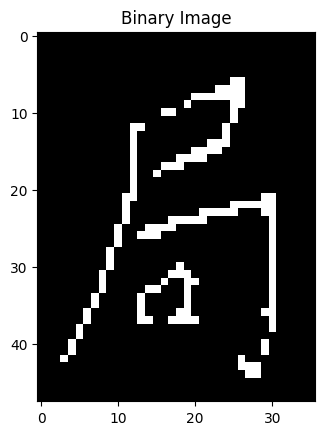

In [34]:
# === Load a sample image ===
img_path = "/content/drive/MyDrive/samples_segmented_chars/p1_upload/RC04844/page_1/c200.png"  # Replace with your image path
img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#img_gray = cv2.resize(img_gray, (128, 128), interpolation=cv2.INTER_NEAREST)  # Normalize
img_gray = np.array(img_gray)
binary = (img_gray == 0).astype(np.uint8)

plt.imshow(binary, cmap='gray')
plt.title("Binary Image")
plt.show()



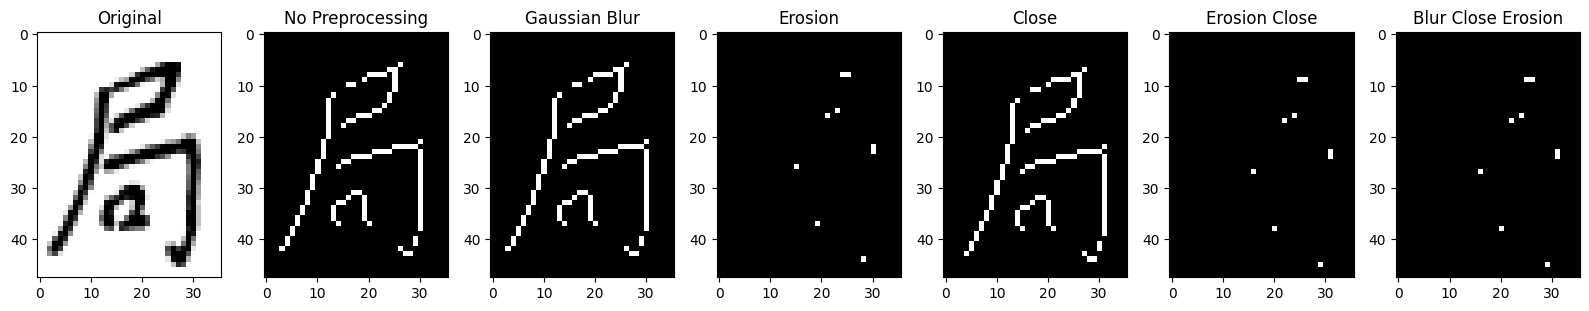

In [35]:

skeleton_orig   = preprocess_and_skeletonize(img_gray, apply_blur=False)
skeleton_blur   = preprocess_and_skeletonize(img_gray, apply_blur=True)
skeleton_erode  = preprocess_and_skeletonize(img_gray, apply_erosion=True)
skeleton_close = preprocess_and_skeletonize(img_gray, apply_close=True)
skeleton_close_erode = preprocess_and_skeletonize(img_gray, apply_erosion=True, apply_close=True)

skeleton_blur_close_erode = preprocess_and_skeletonize(img_gray, apply_blur= True, apply_erosion=True, apply_close=True)

# --- Display side by side ---
fig, axs = plt.subplots(1, 7, figsize=(16, 4))
axs[0].imshow(img_gray, cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(skeleton_orig, cmap='gray')
axs[1].set_title("No Preprocessing")
axs[2].imshow(skeleton_blur, cmap='gray')
axs[2].set_title("Gaussian Blur")
axs[3].imshow(skeleton_erode, cmap='gray')
axs[3].set_title("Erosion")
axs[4].imshow(skeleton_close, cmap='gray')
axs[4].set_title("Close")
axs[5].imshow(skeleton_close_erode, cmap='gray')
axs[5].set_title("Erosion Close")
axs[6].imshow(skeleton_blur_close_erode, cmap='gray')
axs[6].set_title("Blur Close Erosion")
plt.tight_layout()
plt.show()


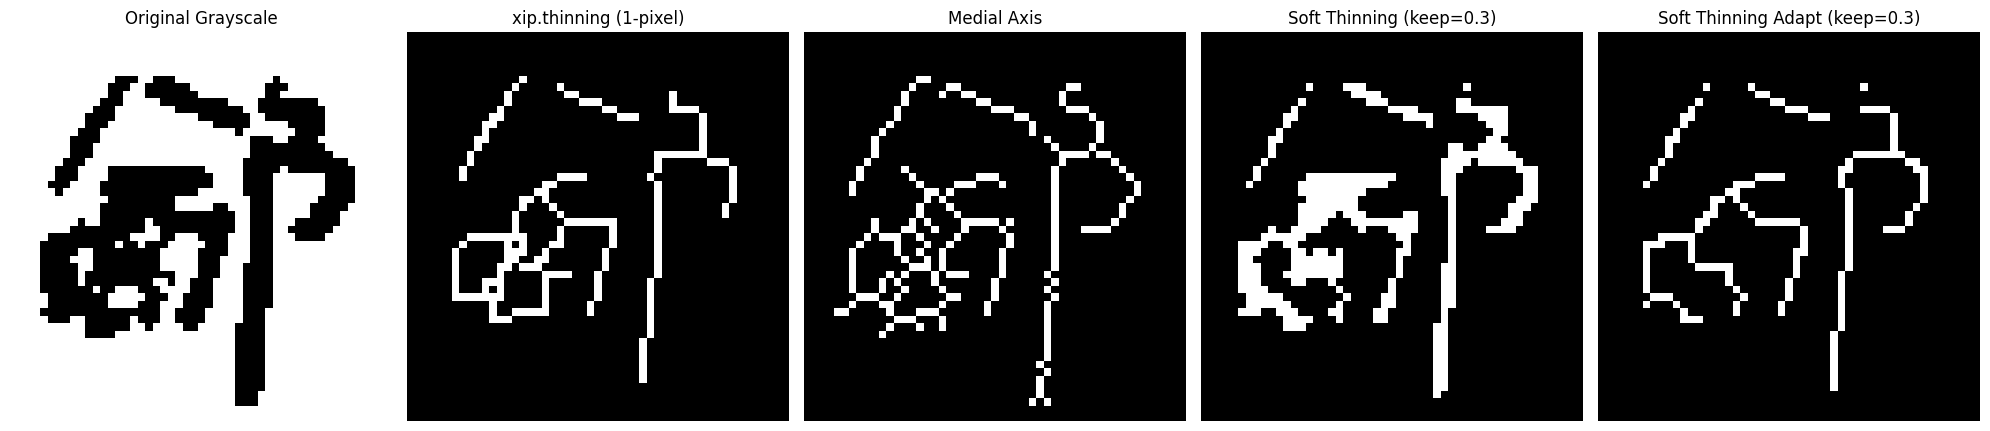

In [113]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.util import invert
from PIL import Image
import cv2.ximgproc as xip

from skimage.morphology import medial_axis

def thinning_opencv(binary_255):
    """OpenCV's thinning to 1-pixel skeleton."""
    return xip.thinning(binary_255)

def medial_axis_skeleton(binary):
    """Medial axis skeleton from skimage."""

    binary_bool = (binary > 0).astype(bool)
    skeleton = medial_axis(binary_bool)
    return (skeleton.astype(np.uint8) * 255)

def soft_thinning(binary, keep_fraction=0.3):
    """Soft thinning using distance transform and fraction threshold."""


    # Distance transform (foreground distance to background)
    dist = cv2.distanceTransform(binary, distanceType=cv2.DIST_L2, maskSize=3)

    # Normalize distance to [0, 1]
    dist_norm = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)


    # Keep central area of strokes
    _, thinned = cv2.threshold(dist_norm, keep_fraction, 1.0, cv2.THRESH_BINARY)

    return (thinned * 255).astype(np.uint8)

import cv2
import numpy as np

def soft_thinning_adapt(binary, keep_fraction=0.3, recombine=True, min_kernel_size=3,skeletonize=False):

    """
    Adaptive soft thinning using distance transform.

    Parameters:
        binary (np.ndarray): Binary image (uint8, 0 and 255).
        keep_fraction (float): Fraction of stroke width to retain (0.01–0.1 typical).
        skeletonize (bool): If True, apply Zhang-Suen skeletonization after thinning.
        visualize (bool): If True, return intermediate maps for debugging.

    Returns:
        np.ndarray: Thinned binary image (uint8, 0 and 255).
        Optional: dict of intermediate maps if visualize=True
    """
    # Ensure binary is 0 and 1
    binary = (binary > 0).astype(np.uint8)

    # Step 1: Distance transform (foreground distance to background)
    dist = cv2.distanceTransform(binary, distanceType=cv2.DIST_L2, maskSize=3)

    # Step 2: Normalize distance to [0, 1]
    dist_norm = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)

    # Step 3: Threshold to keep central stroke regions
    _, thinned = cv2.threshold(dist_norm, keep_fraction, 1.0, cv2.THRESH_BINARY)

    # Step 4: Convert to uint8 binary
    thinned = (thinned * 255).astype(np.uint8)

    # Step 5: Optional skeletonization
    if skeletonize:
        try:
            thinned = cv2.ximgproc.thinning(thinned, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)
        except AttributeError:
            raise ImportError("cv2.ximgproc.thinning requires OpenCV-contrib modules.")


    return thinned


# === Main logic ===

# Load image (ensure it's grayscale)
img_path = "/content/drive/MyDrive/seg_chars/p1/p1/RC05225/page_4/c355.png"  # Replace with your image path
img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

binary = (img_gray == 0).astype(np.uint8)
binary_255 = (img_gray==0).astype(np.uint8)*255

# Process using three methods

thin_xip     = thinning_opencv(binary_255)
thin_medial  = medial_axis_skeleton(binary)
thin_soft    = soft_thinning(binary, keep_fraction=0.3)
thin_soft_adapt = soft_thinning_adapt(binary, keep_fraction=0.3,skeletonize=True)

# Comparison
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
axs[0].imshow(img_gray, cmap='gray')
axs[0].set_title("Original Grayscale")
axs[1].imshow(thin_xip, cmap='gray')
axs[1].set_title("xip.thinning (1-pixel)")
axs[2].imshow(thin_medial, cmap='gray')
axs[2].set_title("Medial Axis")
axs[3].imshow(thin_soft, cmap='gray')
axs[3].set_title("Soft Thinning (keep=0.3)")
axs[4].set_title("Soft Thinning Adapt (keep=0.3)")
axs[4].imshow(thin_soft_adapt, cmap='gray')

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
input_dir = "/content/drive/MyDrive/samples_segmented_chars/p1_upload"
output_dir = "/content/drive/MyDrive/samples_segmented_chars/p1_upload_skeletonized"
process_dataset(input_dir, output_dir)